In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import prophet

%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

Load Data

In [2]:
def load_data(path='C:\\Users\\Oluwajuwon\\Documents\\Smart Systems\\Projects\\Data Science Projects\\combined_data.csv'):
    return pd.read_csv(path)

In [3]:
meters = load_data()
meters.head()

,Unnamed: 0,meter_id,w_timestamp,current,voltage,frequency,power_factor,energy,real_power,reactive_power,apparent_power,tita,hour,time_diff
0,0,OND023,2022-07-12 13:57:30.449294+00:00,0.79,210.1,50.1,0.75,NaN,0.124484,0.109785,0.165979,41.409622,14,0.009675
1,1,OND023,2022-07-12 13:58:42.793010+00:00,0.80,210.6,50.0,0.75,0.002539,0.126360,0.111439,0.168480,41.409622,14,0.009675
2,2,OND023,2022-07-12 14:00:28.080361+00:00,0.85,208.3,50.0,0.74,0.003832,0.131021,0.119088,0.177055,42.268584,15,0.009675
3,3,OND023,2022-07-12 14:01:00.914557+00:00,0.74,208.5,50.0,0.76,0.001069,0.117260,0.100277,0.154290,40.535802,15,0.009675
4,4,OND023,2022-07-12 14:01:34.931821+00:00,0.74,208.1,49.9,0.76,0.001106,0.117035,0.100084,0.153994,40.535802,15,0.009675


In [4]:
meters.shape

(306708, 14)

In [5]:
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306708 entries, 0 to 306707
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      306708 non-null  int64  
 1   meter_id        306708 non-null  object 
 2   w_timestamp     306708 non-null  object 
 3   current         306708 non-null  float64
 4   voltage         306708 non-null  float64
 5   frequency       306708 non-null  float64
 6   power_factor    306708 non-null  float64
 7   energy          306705 non-null  float64
 8   real_power      306708 non-null  float64
 9   reactive_power  306708 non-null  float64
 10  apparent_power  306708 non-null  float64
 11  tita            306708 non-null  float64
 12  hour            306708 non-null  int64  
 13  time_diff       306708 non-null  float64
dtypes: float64(10), int64(2), object(2)
memory usage: 32.8+ MB


In [6]:
on23 = meters[meters['meter_id'] == "OND023"]
oy21 = meters[meters['meter_id'] == "OYO021"]
on21 = meters[meters['meter_id'] == "OND021"]
on24 = meters[meters['meter_id'] == "OND024"]

In [7]:
def clean(df):
    df = df.copy().dropna(axis='index')
    df = df.drop(columns=['Unnamed: 0','meter_id','tita','hour','time_diff'])
    df = df.rename(columns={'w_timestamp':'timestamp'})
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [8]:
df = clean(on23)

In [9]:
df_energy = df[['timestamp','energy']]
df_energy

,timestamp,energy
1,2022-07-12 13:58:42.793010+00:00,0.002539
2,2022-07-12 14:00:28.080361+00:00,0.003832
3,2022-07-12 14:01:00.914557+00:00,0.001069
4,2022-07-12 14:01:34.931821+00:00,0.001106
5,2022-07-12 14:02:10.738666+00:00,0.001164
...,...,...
161079,2022-10-22 21:35:34.272836+00:00,0.003651
161080,2022-10-22 21:36:08.484019+00:00,0.003300
161081,2022-10-22 21:36:43.545834+00:00,0.003368
161082,2022-10-22 21:38:28.735422+00:00,0.007590


In [30]:
df_energy = df_energy.set_index('timestamp').resample('D').sum().reset_index()

In [31]:
data_len = len(df_energy)
test_size = int(0.2*data_len)
train = df_energy[:-test_size]
test = df_energy[-test_size:]

In [33]:
print(train.shape)
print(test.shape)

(83, 2)
(20, 2)


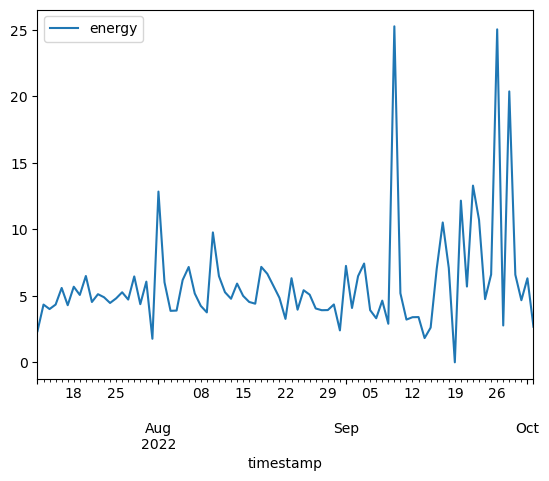

In [34]:
train.set_index('timestamp').plot();

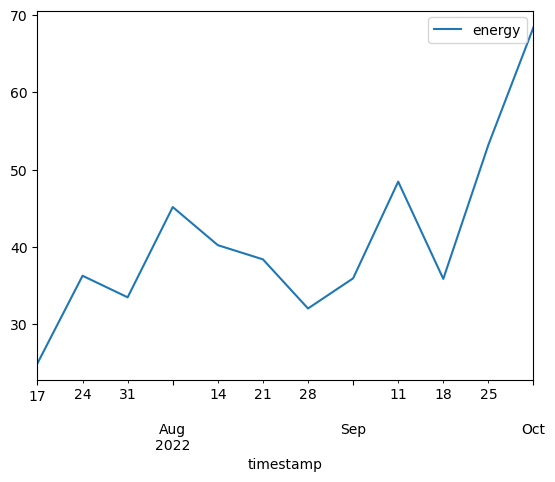

In [35]:
train.set_index('timestamp').resample('W').sum().plot();

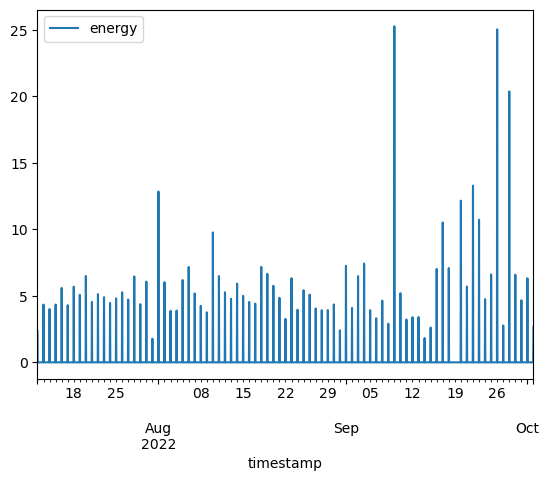

In [36]:
train.set_index('timestamp').resample('H').sum().plot(legend=True);

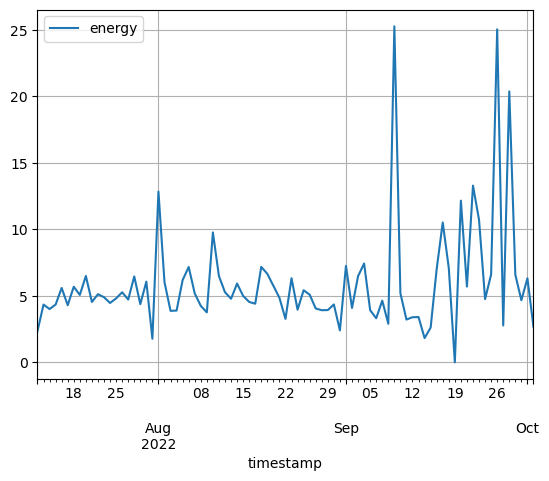

In [37]:
train.set_index('timestamp').resample('D').sum().plot(grid=True);

In [38]:
train,test = train.rename(columns={'timestamp':'ds','energy':'y'}),test.rename(columns={'timestamp':'ds','energy':'y'})
train['ds'] = train['ds'].dt.tz_localize(None)
test['ds'] = test['ds'].dt.tz_localize(None)

In [41]:
from prophet import Prophet

In [42]:
model = prophet.Prophet()

In [43]:
%%time
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Wall time: 2.61 s


In [60]:
%%time
test_fct = model.predict(test)

C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Wall time: 8.57 s


In [63]:
test_fct

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-10-03,7.681459,3.312349,13.611763,7.681459,7.681459,0.615434,0.615434,0.615434,0.615434,0.615434,0.615434,0.0,0.0,0.0,8.296893
1,2022-10-04,7.723529,1.852599,11.842053,7.723529,7.723529,-0.886606,-0.886606,-0.886606,-0.886606,-0.886606,-0.886606,0.0,0.0,0.0,6.836923
2,2022-10-05,7.765599,3.124334,12.794383,7.765599,7.765599,0.164920,0.164920,0.164920,0.164920,0.164920,0.164920,0.0,0.0,0.0,7.930519
3,2022-10-06,7.807669,2.868729,13.168839,7.807669,7.807669,-0.033283,-0.033283,-0.033283,-0.033283,-0.033283,-0.033283,0.0,0.0,0.0,7.774386
4,2022-10-07,7.849739,4.403127,14.323467,7.849739,7.849739,1.433926,1.433926,1.433926,1.433926,1.433926,1.433926,0.0,0.0,0.0,9.283665
5,2022-10-08,7.891809,2.844609,12.851695,7.891809,7.891809,-0.038481,-0.038481,-0.038481,-0.038481,-0.038481,-0.038481,0.0,0.0,0.0,7.853328
6,2022-10-09,7.933879,1.464253,11.580187,7.933879,7.933879,-1.255910,-1.255910,-1.255910,-1.255910,-1.255910,-1.255910,0.0,0.0,0.0,6.677970
7,2022-10-10,7.975949,3.767119,13.684244,7.975949,7.975949,0.615434,0.615434,0.615434,0.615434,0.615434,0.615434,0.0,0.0,0.0,8.591383
8,2022-10-11,8.018019,2.231763,12.101725,8.018019,8.018020,-0.886606,-0.886606,-0.886606,-0.886606,-0.886606,-0.886606,0.0,0.0,0.0,7.131414
9,2022-10-12,8.060090,3.469395,13.622130,8.060090,8.060090,0.164920,0.164920,0.164920,0.164920,0.164920,0.164920,0.0,0.0,0.0,8.225010


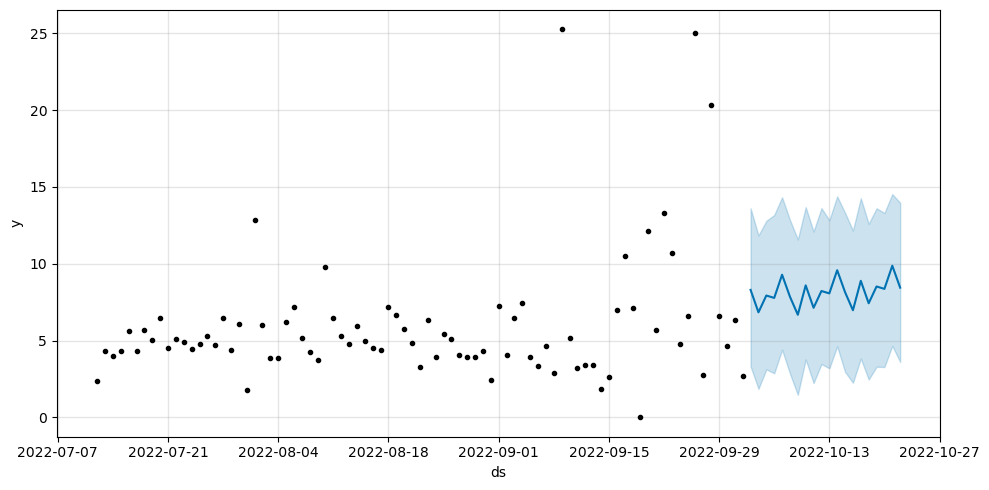

In [66]:
# plot predictions
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(test_fct, ax=ax);

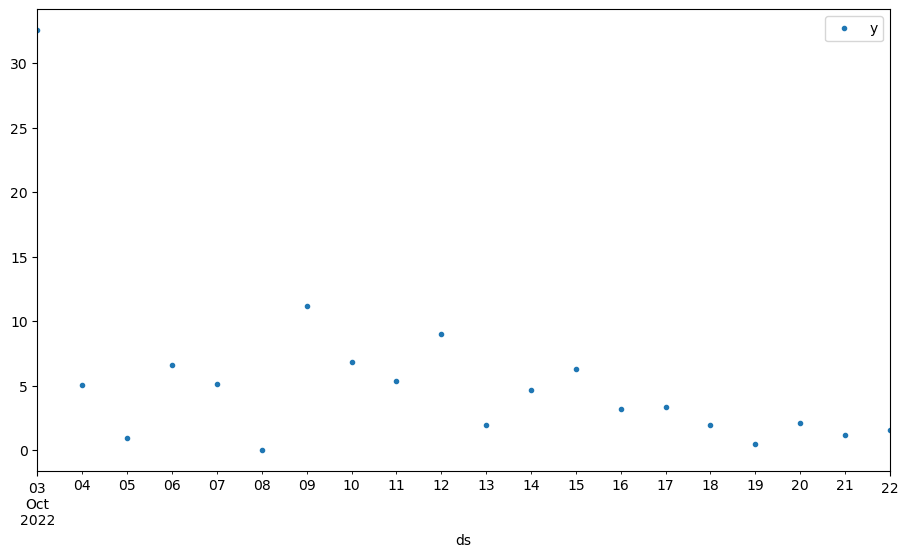

In [67]:
test.set_index('ds').plot(style='.', figsize=(11,6));

C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


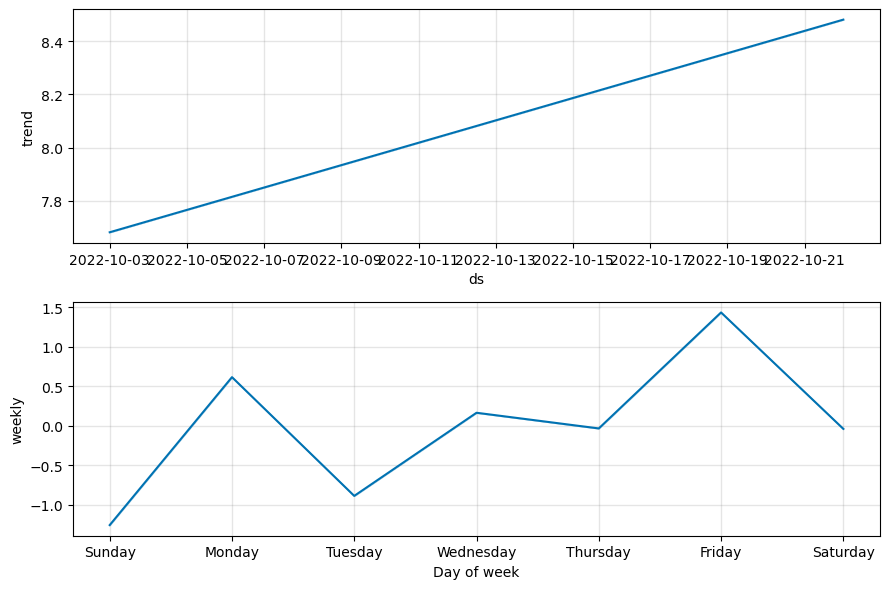

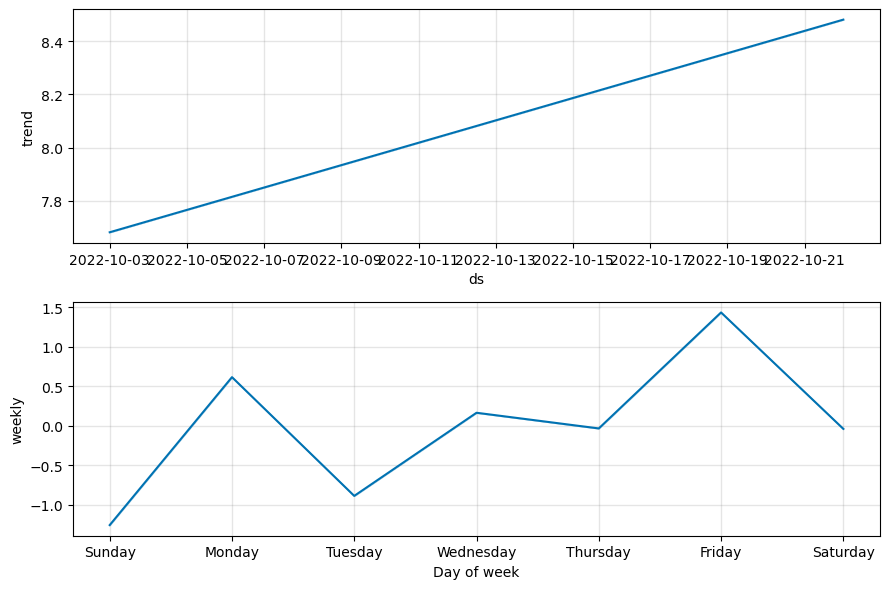

In [68]:
model.plot_components(test_fct)

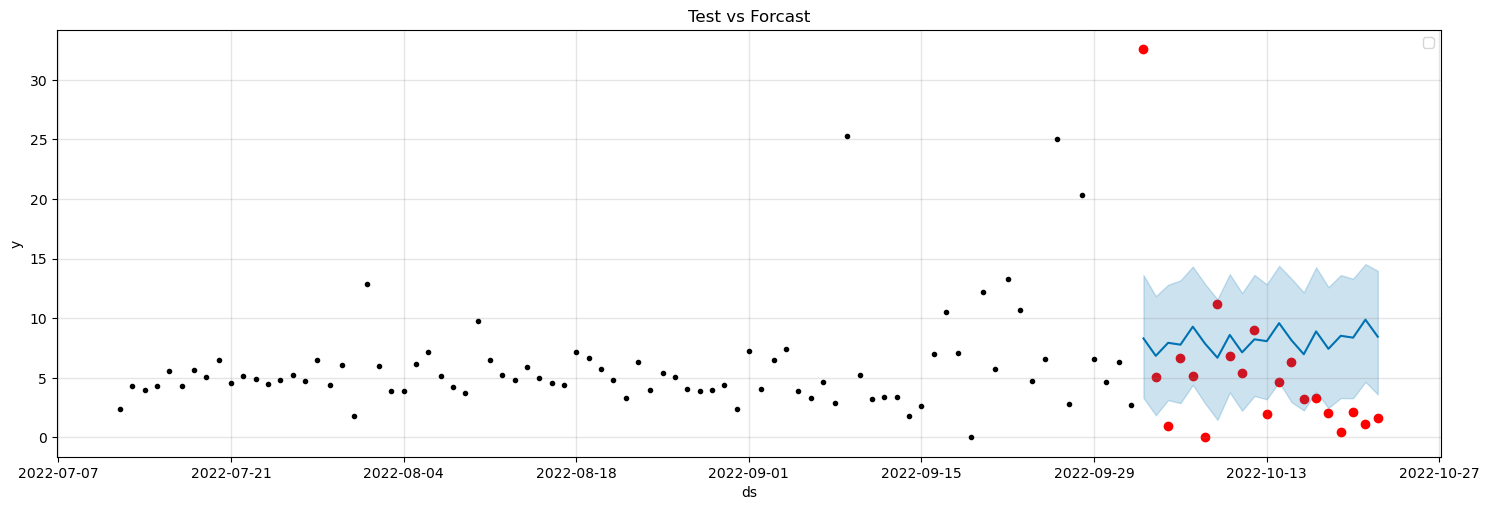

In [71]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test['ds'],test['y'],color='r')
fig = model.plot(test_fct,ax=ax,)

plt.title('Test vs Forcast')
plt.legend();

In [50]:
from datetime import datetime

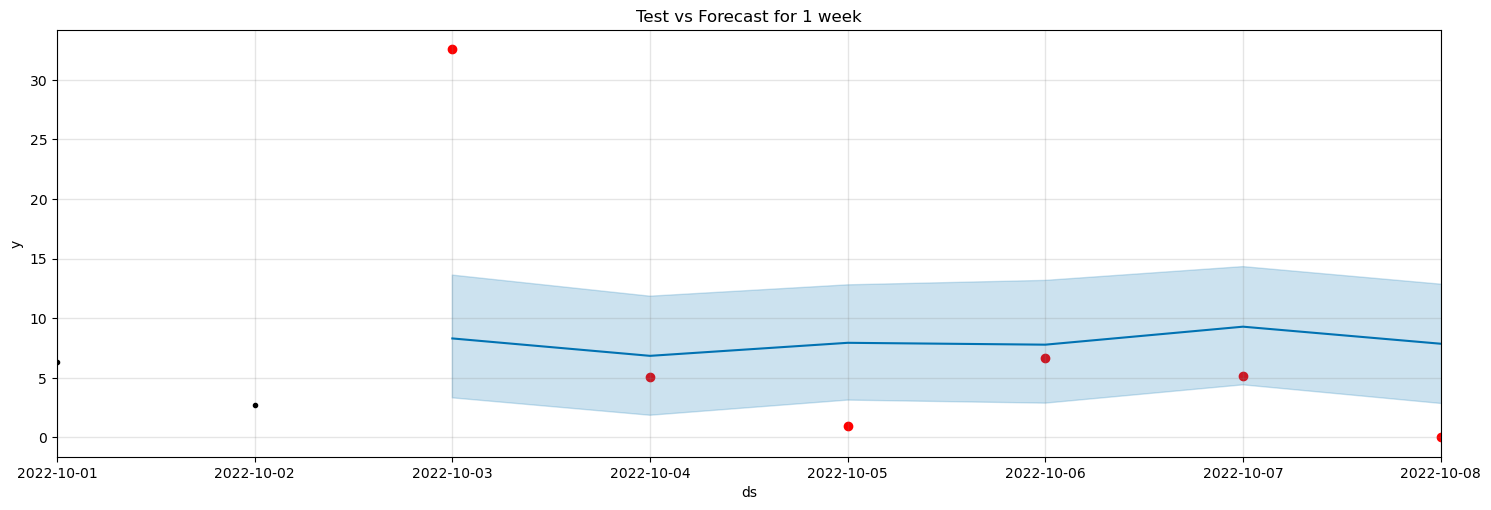

In [73]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test['ds'],test['y'],color='r')
fig = model.plot(test_fct,ax=ax,)
ax.set_xbound(datetime(2022,10,1),upper=datetime(2022,10,8))

plt.title('Test vs Forecast for 1 week');

In [74]:
np.sqrt(mean_squared_error(test['y'],test_fct['yhat']))

7.463449802096227

In [75]:
mean_absolute_error(test['y'], test_fct['yhat'])

5.622505379867243

In [76]:
mean_absolute_percentage_error(y_true=test['y'], y_pred=test_fct['yhat'])

C:\Users\Oluwajuwon\AppData\Local\Temp\ipykernel_5508\2097915832.py:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred)/y_true)) * 100


inf

In [78]:
def smape(y_true,y_pred):
    a = np.mean(np.abs(y_pred - y_true)/(np.abs(y_true) + np.abs(y_pred))/2)
    return round(a*100,2)

In [87]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [89]:
smape(test['y'],test_fct['yhat'])

0.0